In [1]:
from segmate import SegMate
from object_detector import GroundingDINO
import utils
import numpy as np

In [2]:
sm = SegMate(model_type='vit_b', checkpoint='../sam_vit_b.pth', device='cuda', object_detector=None)

In [3]:
od = GroundingDINO()

/home/vahid/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
sm.add_object_detector(od)

In [5]:
image = utils.load_image(image_path='images/building.png')

In [6]:
image.shape

(500, 500, 3)

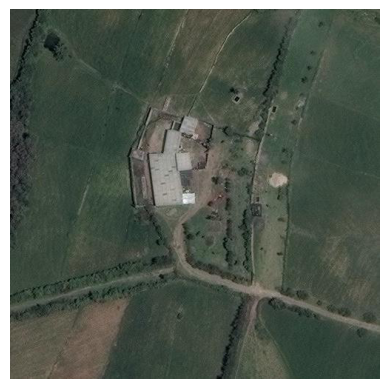

In [7]:
utils.show_image(image=image)

In [8]:
from datasets import load_dataset

dataset = load_dataset("keremberke/satellite-building-segmentation", "mini")

Found cached dataset satellite-building-segmentation (/home/vahid/.cache/huggingface/datasets/keremberke___satellite-building-segmentation/mini/1.0.0/2d4f5155d8a688bdff0915214924fbee078bcc85eb80f4d3c5884b8e319ec0ea)


  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
sample = dataset['train'][1]
image = sample["image"]
bbox = sample['objects']['bbox']
seg_mask = sample['objects']['segmentation']

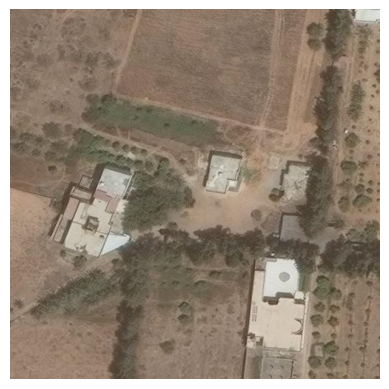

In [10]:
utils.show_image(image=image)

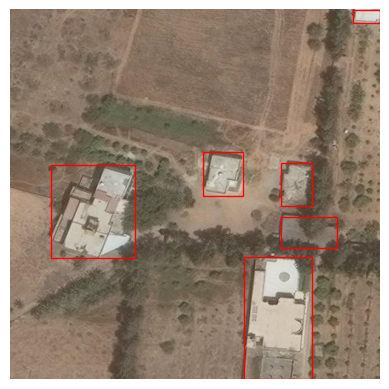

In [11]:
utils.show_bounding_boxes(image=image, bounding_boxes=bbox)

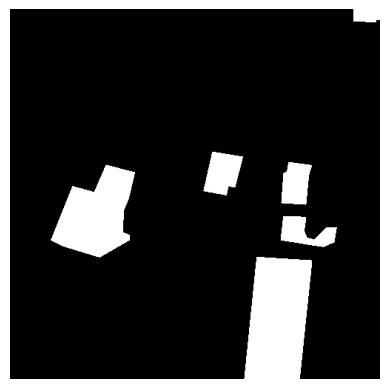

In [12]:
binary_mask = utils.get_segmentation_mask(segmentation_label=seg_mask, size=500)
utils.show_image(binary_mask.reshape(500, 500))

In [13]:
masks = sm.auto_segment(image=np.array(image))

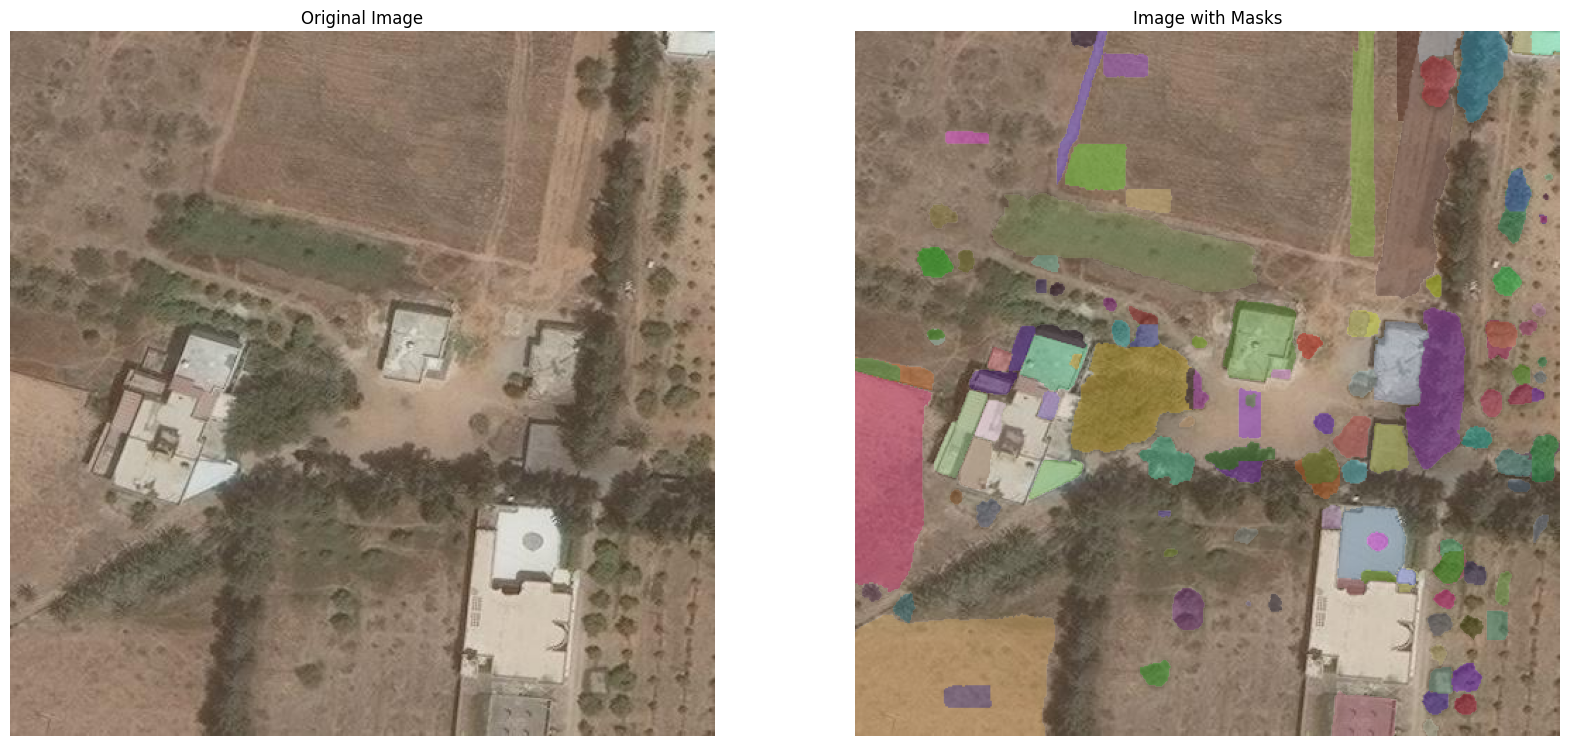

In [14]:
sm.visualize_automask(image=np.array(image), masks=masks)

In [15]:
masks = sm.segment(image=np.array(image), boxes_prompt=utils.convert_bboxes(bbox))

In [16]:
masks.shape

(6, 3, 500, 500)

In [17]:
mask = utils.binarize_mask(masks, sum_all_masks=False)

In [18]:
mask.shape

(6, 500, 500)

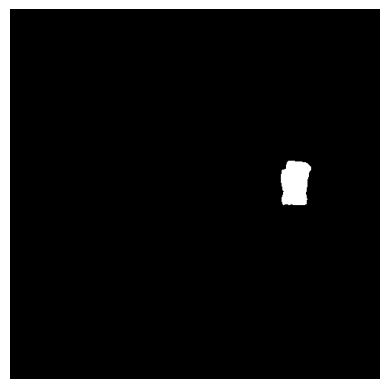

In [19]:
utils.show_image(mask[3])

In [20]:
mask = utils.binarize_mask(masks, sum_all_masks=True)

In [21]:
mask.shape

(500, 500)

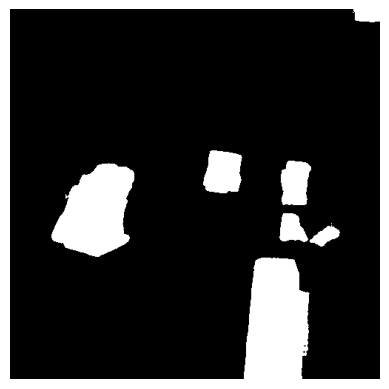

In [22]:
utils.show_image(mask)

In [23]:
masks = sm.segment(image=np.array(image), text_prompt=["building", 0.30, 0.25])

/home/vahid/anaconda3/envs/pytorch/lib/python3.10/site-packages/transformers/modeling_utils.py:830: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/vahid/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/mnt/d/projects/SegMate/segmate.py:226: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_prompt = torch.tensor(boxes_prompt).to(self.device)


In [24]:
mask = utils.binarize_mask(masks, sum_all_masks=True)

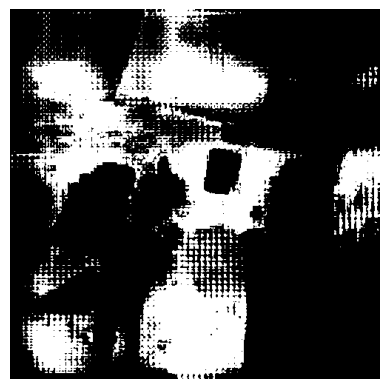

In [25]:
utils.show_image(mask)

In [26]:
point_coords = utils.convert_bboxes2center_points(utils.convert_bboxes(bbox))

In [27]:
point_labels = np.ones((point_coords.shape[0]))

In [28]:
masks = sm.segment(image=np.array(image), points_prompt=[point_coords, point_labels])

In [29]:
mask = utils.binarize_mask(masks, sum_all_masks=True)

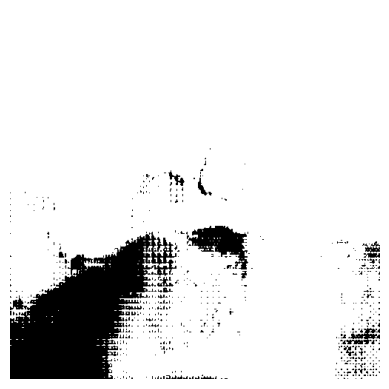

In [30]:
utils.show_image(mask)

In [ ]:
from dataset import BISDataset

bis_dataset = BISDataset(dataset=dataset['train'], 
                         preprocess=sm.sam.preprocess, 
                         img_size=image.size[0], 
                         device=sm.device)

In [ ]:
sm.fine_tune(train_data=bis_dataset, lr=1e-5, num_epochs=1, original_input_size=500)

In [ ]:
# sm.sam.train()
# import torch
# import monai
# from tqdm import tqdm
# # creating the training and validation data loaders
# train_loader = sm.get_dataset(bis_dataset)

# # creating the optimizer and the loss function
# optimizer = torch.optim.Adam(sm.sam.mask_decoder.parameters(), lr=1e-5)
# criterion = monai.losses.DiceCELoss(
#     sigmoid=True, squared_pred=True, reduction='mean')

# for epoch in range(10):
#     epoch_losses = []
#     for input_image, box_prompt, gt_mask in tqdm(train_loader):
#         if box_prompt.shape[1] == 0:
#             continue

#         # forward pass
#         pred_mask = sm.forward_pass(input_image, box_prompt.squeeze(), original_input_size=500)

#         # compute loss
#         loss = criterion(pred_mask, gt_mask)

#         # backward pass (compute gradients of parameters w.r.t. loss)
#         optimizer.zero_grad()
#         loss.backward()

#         # optimize
#         optimizer.step()
#         epoch_losses.append(loss.item())

#     print(f'EPOCH: {epoch}')
#     print(f'Mean loss: {mean(epoch_losses)}')